# AIRBNB SEATTLE
This is an explanatory journey of the data provided by Airbnb seattle.

I've chose this dataset because I travel to Europe twice a year (I reside in Lebanon) and I believe that neighborhood is the most important factor then there are other issues like budget and how close is it to the metro station, then I start going through and reading the reviews because now I have handful of listings I can choose from. I wanted to validate if this applies to other travelers using the Seattle dataset.

# Questions I Believe worth Exploring

1. What are the most popular neighboorhoods in Seattle?
2. Within the neighborhood, do the highest rated listings get the highest revenue?
3. What are the most important variables affecting a listing revenue?

## Importing the needed libraries

In [150]:
# Import the needed libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import feature_extraction
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from pandas.api.types import is_string_dtype, is_numeric_dtype
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import math
from sklearn.model_selection import GridSearchCV

## Importing Data

In [2]:
# Import the required dataset

seattle_cal = pd.read_csv('Data/AirBnB/seattle/calendar.csv')
seattle_list = pd.read_csv('Data/AirBnB/seattle/listings.csv')
seattle_rev = pd.read_csv('Data/AirBnB/seattle/reviews.csv')

In [3]:
# This function enables the me to see all the columns in the dataframe
def display_all(df):
    with pd.option_context('display.max_rows', 1000, 'display.max_columns', 1000):
        display(df)

In [4]:
display_all(seattle_list.head())

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.636289,-122.371025,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.639123,-122.365666,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazi

In [5]:
# There are 92 variables in the listing dataset with 3818 observations 
seattle_list.shape

(3818, 92)

In [6]:
seattle_list.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

Looking at the listing file, we see 92 variables with 3,818 records

In [174]:
df_raw = seattle_list.copy()

## Data Cleansing

In [175]:
def drop_duplicates(df):
    factor_df =  pd.DataFrame()

    for col in df.columns:
        factor_df[col] = df[col].factorize()[0]
        
    dupl_dict = {}
    for index, col_1 in enumerate(factor_df.columns):
        for col_2 in factor_df.columns[index + 1:]:
            if np.all(factor_df[col_1] == factor_df[col_2]):
                dupl_dict[col_1] = col_2
    return dupl_dict

In [176]:
# This function converts datetime variables to new discrete variables and drops existing
def date_to_num(df, col):
    for i in ['day', 'month', 'year']:
        df[col] = pd.to_datetime(df[col])
        df[col+'_'+i] = getattr(df[col].dt, i.lower())

In [177]:
# This function converts continous variables to categotical with levels yes for not null and no for null
def cont_to_cat(df, col):
    condition = [df[col].notnull(), df[col].isnull()]
    choice = ['yes', 'no']
    df[col+'_cat'] = np.select(condition, choice)
    df.drop([col], axis=1, inplace=True)

In [178]:
def remove_regex(df, col):
    df[col] = df[col].str.replace('$', '')
    df[col] = df[col].str.replace(',', '').astype(float)
    df[col].fillna(0, inplace=True)

In [179]:
def cleansing(df):
    
    # Check for columns with same value in every record
    empty_cols = []
    for col in df.columns:
        if np.all(df.groupby(col).id.count() == 3818):
            empty_cols.append(col)
    df.drop(empty_cols, axis=1, inplace=True)
    
    # Drop variables with URL as these are unique to each record and holds little value
    col_url = df.columns[df.columns.str.contains('_url')]
    df.drop(col_url, axis=1, inplace=True)
    
    # Drop variable name because as analysis done above, it holds no value
    df.drop('name', axis=1, inplace=True)
    
    # Drop variables with high number of Null values more than 75%
    null_value = df.columns[df.isnull().sum()/len(df) > .75]
    df.drop(['square_feet'], axis=1,inplace=True)
    
    # Drop duplicate variables
    drop_duplicates(df)
    
    # Manually inspect the drop duplicate function and drop the below 2 columns
    df.drop(['smart_location', 'host_total_listings_count'], axis=1, inplace=True)
    
    # Drop some variables that upon eyeballing looks useless
    df.drop(['state', 'city', 'neighbourhood', 'latitude', 'longitude'], axis=1, inplace=True)
    
    # Fix the error in this specific ZipCode manually
    df.loc[df.zipcode == '99\n98122', 'zipcode'] = '98122'
    
    # Drop all the rest from street as they are visible in other variables like ZipCode
    df.street = df.street.str.split(',', expand=True)[0]
    
    # I will drop this variable because its content and that of the neighbourhood_cleansed is the same with less details
    df.drop('host_neighbourhood', axis=1, inplace=True)
    
    # Convert the values with "$" to  and fill nulls with zero as this shall be free of charge
    remove_regex(df, 'price')
    remove_regex(df, 'extra_people')
    remove_regex(df, 'security_deposit')
    remove_regex(df, 'cleaning_fee')
    
    # We have 3 datetime variables that are of type object and needs to be transfered to date and the to discrete variables
    # This function converts datetime variables to new discrete variables
    df.host_since.fillna('2013-08-30', inplace=True)
    df.first_review.fillna(0, inplace=True)
    df.last_review.fillna(0, inplace=True)
    
    date_to_num(df, 'host_since')
    date_to_num(df, 'first_review')
    date_to_num(df, 'last_review')
    # Drop the existing columns
    df.drop(['host_since', 'first_review', 'last_review'], axis=1, inplace=True)
    
    #This has 26% null values but upon looking at the rest it is all 100% which doesn't make sence as and will drop it
    df.drop('host_acceptance_rate',axis=1, inplace=True)
    
    # Weekly_Price , Monthly_Price variables
    #Since I will be using price in my target variable, I will convert weekly and monthly to categorical variables, 
    #since if it is null, then the host does not engage in long term commitments
    cont_to_cat(df, 'monthly_price')
    cont_to_cat(df, 'weekly_price')
    
    # Continous variables with missing numbers
    fill_zero = ['bathrooms', 'bedrooms', 'review_scores_accuracy', 'review_scores_checkin', 'review_scores_value', 
            'review_scores_location', 'review_scores_cleanliness', 'review_scores_communication', 'review_scores_rating',
            'reviews_per_month', 'host_response_time', 'host_response_rate']
    
    for col in fill_zero:
        df[col].fillna(0, inplace=True)
    
    # filled with most occuring value
    df.zipcode.fillna('98122', inplace=True)
    df.host_is_superhost.fillna('f', inplace=True)
    df.host_has_profile_pic.fillna('t', inplace=True)
    df.host_identity_verified.fillna('t', inplace=True)
    df.beds.fillna('1', inplace=True)
    df.property_type.fillna('House', inplace=True)
    df.host_listings_count.fillna(1, inplace=True)

In [180]:
cleansing(df_raw)

# Feature Engineering

In [181]:
def feat_eng(df):
    # Treating host name
    # The host name doesnt look a lot but upon checking them I noticed that there are singles and couples 
    # hosts which makes it interesting to see if such a variable affects a person decisions
    pattern = '&|And '
    conditions = [(df.host_name.str.contains(pattern) == True), (df.host_name.str.contains(pattern) == False)]
    choices = ['Couple', 'Singles']
    df['host_type'] = np.select(conditions, choices)
    df.drop(['host_name'], axis=1, inplace=True)
    
    # The Amazing Text Variables
    # The below are a bit challenging because they are free text but definitly we can extract some useful keywords
    text_var = list(df[['summary', 'space', 'description', \
               'neighborhood_overview', 'notes', 'transit', 'host_location', 'host_about']].columns)
    
    # Before any treatment, I'll impute the missing variables in each record
    # I will impute with 'No Info' because this will help me track the value of these texts if useful
    df[text_var] = df[text_var].fillna('no info')
    
    # 1. Create a variable with the number of characters
    for col in text_var:
        df[col+'_size'] = df[col].str.len()
    
    # 2. Create size of distinct words
#     for col in text_var:
#         df[col+'_count'] = df[col].str.lower().str.split().str.len()
        
    # 3. Add frequency of top 25 words after dropping all the stopwords
#     txt_vect = feature_extraction.text.TfidfVectorizer(max_features=25, stop_words='english')

#     for col in text_var:
#         matrix = txt_vect.fit_transform(df[col])
#         matrix_df = pd.DataFrame(matrix.toarray(), columns=txt_vect.get_feature_names())
    
#         for i in matrix_df:
#             df[col+'_tf_'+str(i)] = matrix_df[i]    
        
    # Drop the existing variable    
    df.drop(text_var, axis=1, inplace=True)
    
    # Extracting variables from Host Verfication
    # I decided to create dummy variables from host verifications because keeping them in lists will 
    #dillute the value of each communiction channel
    vectorizer = CountVectorizer()
    tk_count = vectorizer.fit_transform(df['host_verifications'])
    contact_list = vectorizer.get_feature_names()
    
    contact_df = pd.DataFrame(tk_count.toarray(), columns=vectorizer.get_feature_names())
    
    for i in contact_df:
        df[col+'_WC_'+ str(i)] = contact_df[i]
        
    # Drop the existing variable      
    df.drop('host_verifications', axis=1, inplace=True)
    

In [182]:
feat_eng(df_raw)

In [183]:
display_all(df_raw.head())

,id,host_id,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,street,neighbourhood_cleansed,neighbourhood_group_cleansed,zipcode,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,host_since_day,host_since_month,host_since_year,first_review_day,first_review_month,first_review_year,last_review_day,last_review_month,last_review_year,monthly_price_cat,weekly_price_cat,host_type,summary_size,space_size,description_size,neighborhood_overview_size,notes_size,transit_size,host_location_size,host_about_size,host_about_WC_amex,host_about_WC_email,host_about_WC_facebook,host_about_WC_google,host_about_WC_jumio,host_about_WC_kba,host_about_WC_linkedin,host_about_WC_manual_offline,host_about_WC_manual_online,host_about_WC_none,host_about_WC_phone,host_about_WC_photographer,host_about_WC_reviews,host_about_WC_sent_id,host_about_WC_weibo
0,241032,956883,within a few hours,96%,f,3.0,t,t,Gilman Dr W,West Queen Anne,Queen Anne,98119,t,Apartment,Entire home/apt,4,1.0,1.0,1,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",85.0,0.0,0.0,2,5.0,1,365,4 weeks ago,14,41,71,346,207,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,moderate,f,f,2,4.07,11,8,2011,1,11,2011,2,1,2016,no,no,Singles,7,1000,1000,7,7,7,34,372,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0
1,953595,5177328,within an hour,98%,t,6.0,t,t,7th Avenue West,West Queen Anne,Queen Anne,98119,t,Apartment,Entire home/apt,4,1.0,1.0,1,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",150.0,100.0,40.0,1,0.0,2,90,today,13,13,16,291,43,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,strict,t,t,6,1.48,21,2,2013,19,8,2013,29,12,2015,yes,yes,Singles,249,1000,1000,167,1000,162,34,74,0,1,1,0,1,0,1,0,0,0,1,0,1,0,0
2,3308979,16708587,within a few hours,67%,f,2.0,t,t,West Lee Street,West Queen Anne,Queen Anne,98119,t,House,Entire home/apt,11,4.5,5.0,7,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",975.0,1000.0,300.0,10,25.0,4,30,5 weeks ago,1,6,17,220,20,97.0,10.0,10.0,10.0,10.0,10.0,10.0,f,strict,f,f,2,1.15,12,6,2014,30,7,2014,3,9,2015,no,no,Singles,241,1000,1000,669,155,202,34,343,0,1,0,1,1,0,0,0,0,0,1,0,1,0,0
3,7421966,9851441,0,0,f,1.0,t,t,8th Avenue West,West Queen Anne,Queen Anne,98119,t,Apartment,Entire home/apt,3,1.0,0.0,2,Real Bed,"{Internet,""Wireless Internet"",Kitchen,""Indoor ...",100.0,0.0,0.0,1,0.0,1,1125,6 months ago,0,0,0,143,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,f,flexible,f,f,1,0.00,6,11,2013,1,1,1970,1,1,1970,yes,yes,Singles,243,7,243,7,7,7,34,7,0,1,1,0,1,0,0,0,0,0,1,0,1,0,0
4,278830,1452570,within an hour,100%,f,2.0,t,t,14th Ave W,West Queen Anne,Queen Anne,98119,t,House,Entire home/apt,6,2.0,3.0,3,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",450.0,700.0,125.0,6,15.0,1,1125,7 weeks ago,30,60,90,365,38,92.0,9.0,9.0,10.0,10.0,9.0,9.0,f,strict,f,f,1,0.89,29,11,2011,10,7,2012,24,10,2015,no,no,Singles,184,488,1000,492,9,295,34,354,0,1,1,0,0,1,0,0,0,0,1,0,1,0,0


In [184]:
df_raw.shape

(3818, 82)

In [185]:
def treat_amenities(data, col):
    vectorizer = CountVectorizer(stop_words='english') 
    amenities_features = vectorizer.fit_transform(data[col])
    amenities_df = pd.DataFrame(amenities_features.toarray(), columns=vectorizer.get_feature_names())
    data.drop([col], axis=1, inplace=True)
    
    return pd.concat([data.reset_index(), amenities_df.reset_index()], axis=1)

In [186]:
df = treat_amenities(df_raw, 'amenities')

In [187]:
df.drop('index', axis=1, inplace=True)

In [188]:
df.shape

(3818, 143)

In [189]:
display_all(df.head())

,id,host_id,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,street,neighbourhood_cleansed,neighbourhood_group_cleansed,zipcode,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,host_since_day,host_since_month,host_since_year,first_review_day,first_review_month,first_review_year,last_review_day,last_review_month,last_review_year,monthly_price_cat,weekly_price_cat,host_type,summary_size,space_size,description_size,neighborhood_overview_size,notes_size,transit_size,host_location_size,host_about_size,host_about_WC_amex,host_about_WC_email,host_about_WC_facebook,host_about_WC_google,host_about_WC_jumio,host_about_WC_kba,host_about_WC_linkedin,host_about_WC_manual_offline,host_about_WC_manual_online,host_about_WC_none,host_about_WC_phone,host_about_WC_photographer,host_about_WC_reviews,host_about_WC_sent_id,host_about_WC_weibo,24,accessible,aid,air,allowed,bedroom,breakfast,building,buzzer,cable,carbon,card,cat,check,conditioning,detector,dog,door,doorman,dryer,elevator,essentials,events,extinguisher,family,fireplace,free,friendly,gym,hair,hangers,heating,hot,hour,indoor,intercom,internet,iron,kid,kit,kitchen,laptop,live,lock,monoxide,parking,pet,pets,pool,premises,property,safety,shampoo,smoke,smoking,suitable,tub,tv,washer,wheelchair,wireless,workspace
0,241032,956883,within a few hours,96%,f,3.0,t,t,Gilman Dr W,West Queen Anne,Queen Anne,98119,t,Apartment,Entire home/apt,4,1.0,1.0,1,Real Bed,85.0,0.0,0.0,2,5.0,1,365,4 weeks ago,14,41,71,346,207,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,moderate,f,f,2,4.07,11,8,2011,1,11,2011,2,1,2016,no,no,Singles,7,1000,1000,7,7,7,34,372,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,1,0
1,953595,5177328,within an hour,98%,t,6.0,t,t,7th Avenue West,West Queen Anne,Queen Anne,98119,t,Apartment,Entire home/apt,4,1.0,1.0,1,Real Bed,150.0,100.0,40.0,1,0.0,2,90,today,13,13,16,291,43,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,strict,t,t,6,1.48,21,2,2013,19,8,2013,29,12,2015,yes,yes,Singles,249,1000,1000,167,1000,162,34,74,0,1,1,0,1,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,1,0,0,0,2,0,0,0,1,0,1,0,1,1,0,1,1,0,0,0,1,0,0,0,1,2,0,1,1,1,0,0,0,1,1,0,0,0,1,0,1,0,1,0,0,0,1,1,0,2,0
2,3308979,16708587,within a few hours,67%,f,2.0,t,t,West Lee Street,West Queen Anne,Queen Anne,98119,t,House,Entire home/apt,11,4.5,5.0,7,Real Bed,975.0,1000.0,300.0,10,25.0,4,30,5 weeks ago,1,6,17,220,20,97.0,10.0,10.0,10.0,10.0,10.0,10.0,f,strict,f,f,2,1.15,12,6,2014,30,7,2014,3,9,2015,no,no,Singles,241,1000,1000,669,155,202,34,343,0,1,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,1,1,0,1,0,1,2,1,0,0,1,0,1,0,0,1,1,1,1,0,0,0,1,1,0,1,0,2,0,1,0,1,0,1,0,1,1,0,2,0,1,1,0,1,1,0,0,1,2,1,0,1,0
3,7421966,9851441,0,0,f,1.0,t,t,8th Avenue West,West Queen Anne,Queen Anne,98119,t,Apartment,Entire home/apt,3,1.0,0.0,2,Real Bed,100.0,0.0,0.0,1,0.0,1,1125,6 months ago,0,0,0,143,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,f,flexible,f,f,1,0.00,6,11,2013,1,1,1970,1,1,1970,yes,yes,Singles,243,7,243,7,7,7,34,7,0,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,0,0,0,1,0,1,0,1,1,1,0,1,0,0,0,1,0,0,1,0,2,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,1,0
4,278830,1452570,within an hour,100%,f,2.0,t,t,14th Ave W,West Queen Anne,Queen Anne,98119,t,House,Entire home/apt,6,2.0,3.0,3,Real Bed,450.0,700.0,125.0,6,15.0,1,1125,7 weeks ago,30,60,90,365,38,92.0,9.0,9.0,10.0,1

We now have 351 variables fully encoded to be used for data analysis

## Looking for a Target Variable

The closest is price, but it can't be a clear target variables because the listings we are comapring here are not the same especially in number of people it can accommodate at once

In [190]:
df.room_type.value_counts()

Entire home/apt    2541
Private room       1160
Shared room         117
Name: room_type, dtype: int64

In [191]:
df.groupby('room_type').price.mean()

room_type
Entire home/apt    155.843369
Private room        75.044828
Shared room         47.547009
Name: price, dtype: float64

As visible, average price varies a lot between the different types of listings

I will assume that every review is a booking and it makes sense to include the minimum number of nights per review and multiply them by the price per note

In [192]:
df['rev'] = df.price * df.minimum_nights * df.number_of_reviews

In [193]:
round(df['rev'].describe(), 2)

count       3818.00
mean        5231.80
std        22626.74
min            0.00
25%          260.00
50%         1535.00
75%         5265.00
max      1200000.00
Name: rev, dtype: float64

We have a listing that generated 1,200,000 USD which is a probably wrong

In [194]:
df.minimum_nights.describe()

count    3818.000000
mean        2.369303
std        16.305902
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max      1000.000000
Name: minimum_nights, dtype: float64

In [195]:
# I will drop this column because it looks like an error in the data
df.drop(2760, inplace=True)

## Treating Categorical Variables

In [196]:
df.monthly_price_cat.value_counts()

no     2300
yes    1517
Name: monthly_price_cat, dtype: int64

In [197]:
# Convert variables of type object to categorical variables
def to_cat(df):
    for col in df.columns:
        if df[col].dtype == object:
            df[col] = df[col].astype('category')

In [198]:
to_cat(df)

After converting the object variables to categrical, I will encode them but will not create dummy variables because I will use a RandomForestRegressor which usually yields same results for both categorical and dummy variables

In [199]:
# This encodes all categorical variables
def encode_cat(df):
    for col in df.columns:
        if not is_numeric_dtype(df[col]):
            df[col] = df[col].cat.codes+1

In [200]:
encode_cat(df)

In [201]:
display_all(df.head())

,id,host_id,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,street,neighbourhood_cleansed,neighbourhood_group_cleansed,zipcode,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,host_since_day,host_since_month,host_since_year,first_review_day,first_review_month,first_review_year,last_review_day,last_review_month,last_review_year,monthly_price_cat,weekly_price_cat,host_type,summary_size,space_size,description_size,neighborhood_overview_size,notes_size,transit_size,host_location_size,host_about_size,host_about_WC_amex,host_about_WC_email,host_about_WC_facebook,host_about_WC_google,host_about_WC_jumio,host_about_WC_kba,host_about_WC_linkedin,host_about_WC_manual_offline,host_about_WC_manual_online,host_about_WC_none,host_about_WC_phone,host_about_WC_photographer,host_about_WC_reviews,host_about_WC_sent_id,host_about_WC_weibo,24,accessible,aid,air,allowed,bedroom,breakfast,building,buzzer,cable,carbon,card,cat,check,conditioning,detector,dog,door,doorman,dryer,elevator,essentials,events,extinguisher,family,fireplace,free,friendly,gym,hair,hangers,heating,hot,hour,indoor,intercom,internet,iron,kid,kit,kitchen,laptop,live,lock,monoxide,parking,pet,pets,pool,premises,property,safety,shampoo,smoke,smoking,suitable,tub,tv,washer,wheelchair,wireless,workspace,rev
0,241032,956883,4,43,1,3.0,2,2,655,82,13,15,2,1,1,4,1.0,1.0,1,5,85.0,0.0,0.0,2,5.0,1,365,20,14,41,71,346,207,95.0,10.0,10.0,10.0,10.0,9.0,10.0,1,2,1,1,2,4.07,11,8,2011,1,11,2011,2,1,2016,1,1,3,7,1000,1000,7,7,7,34,372,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,1,0,17595.0
1,953595,5177328,5,45,2,6.0,2,2,420,82,13,15,2,1,1,4,1.0,1.0,1,5,150.0,100.0,40.0,1,0.0,2,90,33,13,13,16,291,43,96.0,10.0,10.0,10.0,10.0,10.0,10.0,1,3,2,2,6,1.48,21,2,2013,19,8,2013,29,12,2015,2,2,3,249,1000,1000,167,1000,162,34,74,0,1,1,0,1,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,1,0,0,0,2,0,0,0,1,0,1,0,1,1,0,1,1,0,0,0,1,0,0,0,1,2,0,1,1,1,0,0,0,1,1,0,0,0,1,0,1,0,1,0,0,0,1,1,0,2,0,12900.0
2,3308979,16708587,4,21,1,2.0,2,2,1199,82,13,15,2,10,1,11,4.5,5.0,7,5,975.0,1000.0,300.0,10,25.0,4,30,23,1,6,17,220,20,97.0,10.0,10.0,10.0,10.0,10.0,10.0,1,3,1,1,2,1.15,12,6,2014,30,7,2014,3,9,2015,1,1,3,241,1000,1000,669,155,202,34,343,0,1,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,1,1,0,1,0,1,2,1,0,0,1,0,1,0,0,1,1,1,1,0,0,0,1,1,0,1,0,2,0,1,0,1,0,1,0,1,1,0,2,0,1,1,0,1,1,0,0,1,2,1,0,1,0,78000.0
3,7421966,9851441,1,1,1,1.0,2,2,428,82,13,15,2,1,1,3,1.0,0.0,2,5,100.0,0.0,0.0,1,0.0,1,1125,25,0,0,0,143,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,1,1,0.00,6,11,2013,1,1,1970,1,1,1970,2,2,3,243,7,243,7,7,7,34,7,0,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,2,0,0,0,1,0,1,0,1,1,1,0,1,0,0,0,1,0,0,1,0,2,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,1,0,0.0
4,278830,1452570,5,2,1,2.0,2,2,49,82,13,15,2,10,1,6,2.0,3.0,3,5,450.0,700.0,125.0,6,15.0,1,1125,28,30,60,90,365,38,92.0,9.0,9.0,10.0,10.0,9.0,9.0,1,3,1,1,1,0.89,29,11,2011,10,7,2012,24,10,2015,1,1,3,184,488,1000,492,9,295,34,354,0,1,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,2,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,1,0,0,0,0,2,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,2,0,0,1,0,17100.0


In [202]:
df.shape

(3817, 144)

## Building a model that will help us answer our questions

Since our dataframe is all encoded, we can use it to sun some model, but first we need to seperate the taregt variable and create a training/testing dataset

In [203]:
# Splitting the data between 
data = df.drop('rev', axis=1) 
y = df.rev

In [204]:
len(df)

3817

In [205]:
# Splitting between training and testing
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.20, random_state=42)

## Random Forest

I will use random forest regressor to predict a listing revenue

In [ ]:
estimator = RandomForestRegressor()
param_grid = { "n_estimators"      : [10,20,30],
              "max_features"      : ["auto", "sqrt", "log2"],
              "min_samples_split" : [2,4,8],
              
            }

    grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=5)

In [206]:
model = RandomForestRegressor(n_estimators=20,n_jobs=-1)
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [207]:
def rmse(x,y):
    return math.sqrt(((x-y)**2).mean())

In [208]:
preds = np.stack([t.predict(X_test) for t in model.estimators_])
preds[:,0], np.mean(preds[:,0]), y_test[0]

(array([1500., 1600., 1390., 1650., 1700., 1700., 1540., 1600., 1390.,
        1650., 1390., 1700., 1500., 1390., 2350., 1700., 1600., 1630.,
        1980., 1400.]), 1618.0, 17595.0)

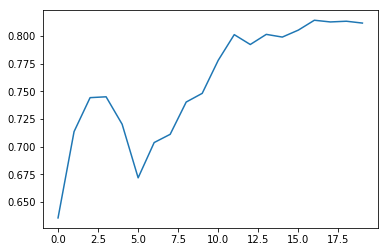

In [209]:
plt.plot([r2_score(y_test, np.mean(preds[:i+1], axis=0)) for i in range(20)]);

In [210]:
rmse(model.predict(X_train), y_train), rmse(model.predict(X_test), y_test)

(8315.27293708854, 5258.809596422002)

In [211]:
print('Training_Score: ', model.score(X_train, y_train))
print('Testing_Score: ', model.score(X_test, y_test))

Training_Score:  0.8853987796370134
Testing_Score:  0.8114694720359876


In [212]:
# Feature Importance
def feat_imp(model, df):
    return pd.DataFrame({'Features':X_train.columns, 'Importance':model.feature_importances_}).sort_values('Importance', ascending=False)

In [213]:
feat_imp = feat_imp(model, df)

In [214]:
feat_imp[:30]

,Features,Importance
25,minimum_nights,0.747952
32,number_of_reviews,0.158170
20,price,0.040404
8,street,0.006231
45,reviews_per_month,0.005717
138,tv,0.002767
122,laptop,0.002697
61,neighborhood_overview_size,0.002671
0,id,0.002369
22,cleaning_fee,0.002272


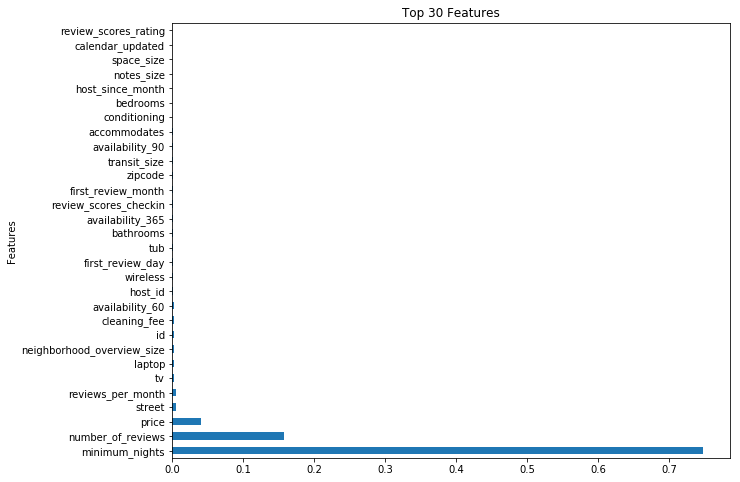

In [215]:
feat_imp[:30].plot('Features', kind='barh',title='Top 30 Features', figsize=(10, 8), legend=False)
plt.show()

# Question 1: What are the most popular neighboorhoods in Seattle?

In [119]:
top_neighbour = df.neighbourhood_cleansed.value_counts()[:10]
top_neighbour

10    396
5     234
80    167
22    158
48    135
77    122
75    119
21    108
13    103
39     94
Name: neighbourhood_cleansed, dtype: int64

In [160]:
top_10_hoods = list(top_neighbour.to_frame().index)

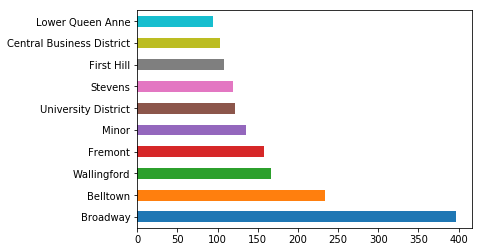

In [110]:
top_neighbour.plot('barh')
plt.show()

Although we don't have the number of booking per listing but for the fact that Broadway has almost double the number of lsiting in comparison to the next neighborhood in list means that this is a popular destination in Seattle

Lets check some attributed of this neighborhood that might be interesting

In [144]:
df[df.neighbourhood_cleansed == 'Broadway'].price.describe()

count    397.000000
mean     123.889169
std       77.628634
min       25.000000
25%       79.000000
50%      100.000000
75%      150.000000
max      673.000000
Name: price, dtype: float64

In [ ]:
top_10_hoods

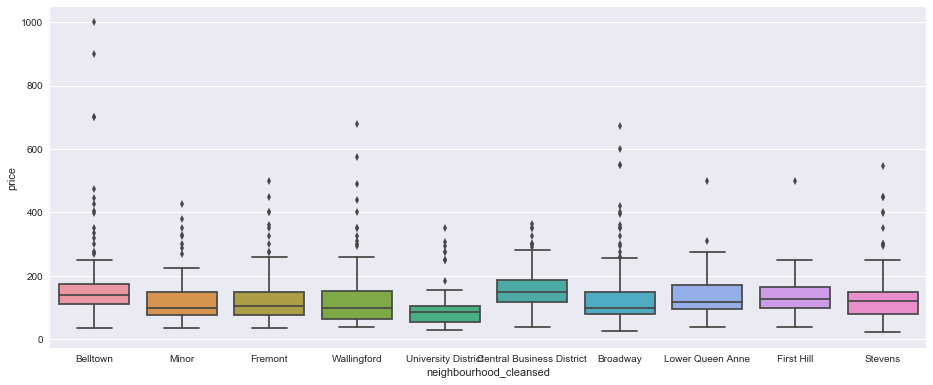

In [172]:
sns.set(rc={'figure.figsize':(15.7,6.27)})
sns.boxplot(x='neighbourhood_cleansed', y='price', data=df[df.neighbourhood_cleansed.isin(top_10_hoods)])
plt.show()